<a href="https://colab.research.google.com/github/roasfora/Project_CRM/blob/main/Aula_06(CRM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/sercanyesiloz/crm-analytics/input

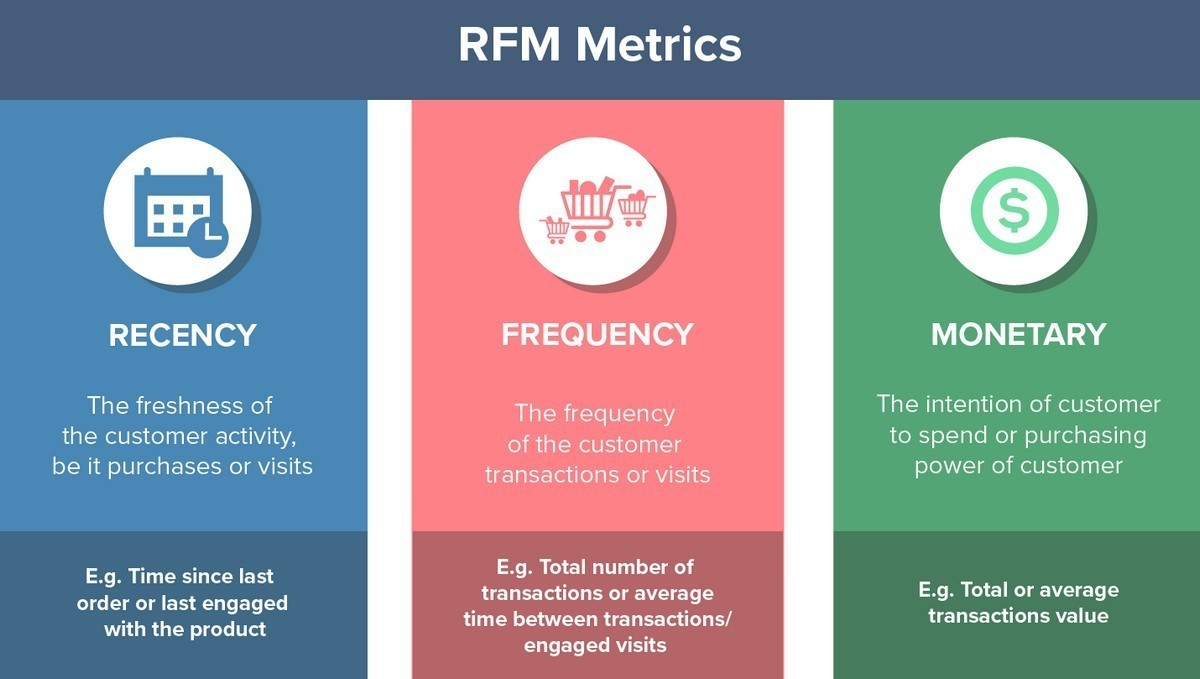

**Como funciona a análise RFM?**
Cálculo das métricas RFM:

Recência: Determina quantos dias se passaram desde a última compra.
Frequência: Conta o número total de transações ou interações do cliente.
Monetário: Calcula o total gasto pelo cliente (soma de todas as transações).


**Atribuição de pontuações:**

Cada métrica (R, F, M) é dividida em grupos ou segmentos (geralmente em uma escala de 1 a 5).
Pontuações mais altas indicam clientes mais valiosos em cada dimensão:
Recência: 5 (mais recente) a 1 (menos recente).
Frequência: 5 (mais frequente) a 1 (menos frequente).
Monetário: 5 (maior valor gasto) a 1 (menor valor gasto).

**Criação do Score RFM:**

Combina as pontuações de Recência, Frequência e Monetário em um único score, como 555, 123, etc.
Exemplo:
Um cliente com score 555 é recente, frequente e gastou muito.
Um cliente com score 111 é inativo, comprou poucas vezes e gastou pouco.

**Segmentação dos clientes:**

Clientes são agrupados em categorias com base em seu RFM Score, como:
Clientes Top: RFM 555 (mais recentes, frequentes e valiosos).
Clientes Frequentes: Alta frequência, mas menos recentes.
Grandes Gastadores: Alto valor monetário, mas baixa frequência.
Clientes Comuns: Engajamento e gasto médios.


Primeiras linhas do dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  

<ipython-input-5-34f8bd6a008a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)
<ipython-input-5-34f8bd6a008a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])



Distribuição dos Segmentos:
Segmento
Cliente Comum        2846
Recém-Ativo           560
Cliente Frequente     475
Cliente Top           316
Grande Gastador       175
Name: count, dtype: int64

Resultados RFM exportados para 'rfm_resultados.csv'.


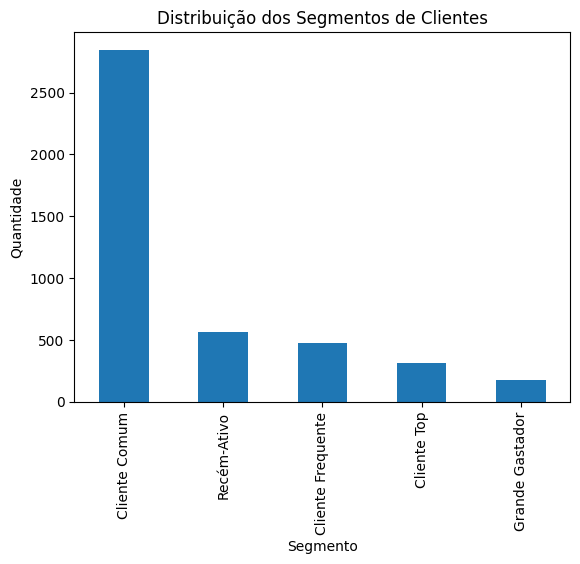

In [ ]:
import pandas as pd
import datetime as dt

# **1. Carregar o Dataset**
file_path = '/content/crm.csv'

# Carregando o dataset com codificação apropriada
df = pd.read_csv(file_path, encoding='latin1')  # Tente 'latin1' ou 'ISO-8859-1'

# Visualizar as primeiras linhas do dataset
print("\nPrimeiras linhas do dataset:")
print(df.head())

# Informações básicas do dataset
print("\nInformações do dataset:")
print(df.info())

# **2. Preparação dos Dados**

# Calcular o valor total da compra (TotalPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Verificar valores ausentes
print("\nValores ausentes:")
print(df.isnull().sum())

# Remover linhas com CustomerID ausente (necessário para RFM)
df = df.dropna(subset=['CustomerID'])

# Converter CustomerID para inteiro
df['CustomerID'] = df['CustomerID'].astype(int)

# Converter a coluna InvoiceDate para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Criar uma data de referência (última data da transação + 1)
data_referencia = df['InvoiceDate'].max() + dt.timedelta(days=1)

# **3. Calcular Métricas RFM**

# Recency: Dias desde a última compra
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (data_referencia - recency['InvoiceDate']).dt.days

# Frequency: Número de transações por cliente
frequency = df.groupby('CustomerID').size().reset_index(name='Frequency')

# Monetary: Valor total gasto por cliente
monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index(name='Monetary')

# Combinar as métricas RFM
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

# **4. Atribuir Pontuações**

# Pontuações de Recency (1 a 5, quintis)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Pontuações de Frequency e Monetary (1 a 5, quintis)
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Criar o Score RFM
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# **5. Segmentar os Clientes**

# Função para segmentar os clientes
def segmentar_cliente(score):
    if score == '555':
        return 'Cliente Top'
    elif score[0] == '5':  # Alta Recência
        return 'Recém-Ativo'
    elif score[1] == '5':  # Alta Frequência
        return 'Cliente Frequente'
    elif score[2] == '5':  # Alto Valor Monetário
        return 'Grande Gastador'
    else:
        return 'Cliente Comum'

rfm['Segmento'] = rfm['RFM_Score'].apply(segmentar_cliente)

# **6. Analisar e Exportar os Resultados**

# Contagem de clientes por segmento
print("\nDistribuição dos Segmentos:")
print(rfm['Segmento'].value_counts())

# Exportar os resultados para CSV
rfm.to_csv('/content/rfm_resultados.csv', index=False)
print("\nResultados RFM exportados para 'rfm_resultados.csv'.")

# Gráfico de distribuição dos segmentos
import matplotlib.pyplot as plt

rfm['Segmento'].value_counts().plot(kind='bar', title='Distribuição dos Segmentos de Clientes', xlabel='Segmento', ylabel='Quantidade')
plt.show()
